<a href="https://colab.research.google.com/github/Koushikgoud/document_clustering/blob/main/kmeans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

First, we will import all the python libraries that we need.  

*   Data preparation (Pandas, Numpy, Scikit-Learn)
*   Decomposition (Principal Component Analysis, PCA)
*   Document clustering (KMeans)
*   Cluster Optimization (linear_sum_assignment)
*   Evaluation metrics (accuracy_score, adjusted_rand_score, normalized_mutual_info_score) 
*   Visualization (pyplot and t-SNE from sklearn.manifold)


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
%matplotlib inline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score as nmi
from sklearn.metrics import adjusted_rand_score as ari
from sklearn.metrics import accuracy_score as acc
from scipy.optimize import linear_sum_assignment
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE

Since we are running on Google Colab, we need to install StellarGraph which is a library that offers several state-of-art algorithms for Graph Machine Learning, contains several graph structured data like the Cora Dataset which we are using in this project. 

In this step, we are getting our data mapped using os.path.join

In [ ]:
import sys
if 'google.colab' in sys.modules:
  %pip install -q stellargraph[demos]==1.0.0rc1
from stellargraph.datasets import Cora
import os
cora = Cora()
cora.download()
cora_cites_file = os.path.join(cora.base_directory, "cora.cites")
cora_content_file = os.path.join(cora.base_directory, "cora.content")

The Cora dataset consists of academic publications as the nodes and the citations between them as the links. 
If publication A cites publication B, then the graph has an edge from A (source) to B (target) in our cora_cites data. 
This citation network consists of 5,429 links.

In this step, pandas reads in the csv

In [ ]:
cora_cites = pd.read_csv(
    cora_cites_file,
    sep = "\t",
    header = None,
    names = ["target", "source"]
)
cora_cites

,target,source
0,35,1033
1,35,103482
2,35,103515
3,35,1050679
4,35,1103960
...,...,...
5424,853116,19621
5425,853116,853155
5426,853118,1140289
5427,853155,853118


The Cora dataset consists of 2,708 scientific publications classified into one of seven classes, and our model will learn to predict this subject using KMeans clustering algorithm.

In [ ]:
cora_feature_names = [f"w{i}" for i in range(1433)]
cora_raw_content = pd.read_csv(
    cora_content_file,
    sep="\t",
    header = None,
    names = ["id", *cora_feature_names, "subject"]
)
cora_raw_content

,id,w0,w1,w2,w3,w4,w5,w6,w7,w8,...,w1424,w1425,w1426,w1427,w1428,w1429,w1430,w1431,w1432,subject
0,31336,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,Neural_Networks
1,1061127,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,Rule_Learning
2,1106406,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Reinforcement_Learning
3,13195,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Reinforcement_Learning
4,37879,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Probabilistic_Methods
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2703,1128975,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Genetic_Algorithms
2704,1128977,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Genetic_Algorithms
2705,1128978,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Genetic_Algorithms
2706,117328,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Case_Based


Using `value_counts()` method to display class distribution of all the nodes present in the cora dataset. This will be the ground truth using which we evaluate the accuracy of our model.

In [ ]:
class_distribution = cora_raw_content['subject'].value_counts()
class_distribution

Neural_Networks           818
Probabilistic_Methods     426
Genetic_Algorithms        418
Theory                    351
Case_Based                298
Reinforcement_Learning    217
Rule_Learning             180
Name: subject, dtype: int64

Using pyplot to represent the class distribution as an histogram 

Text(0, 0.5, 'Frequency')

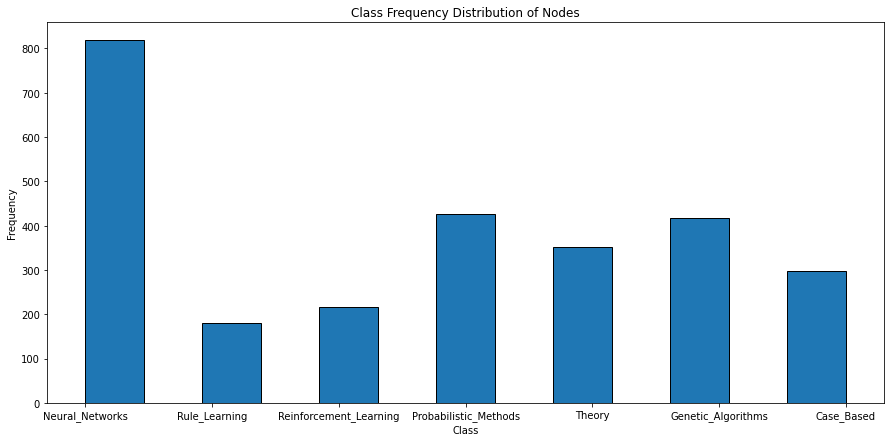

In [ ]:
fig = plt.figure(figsize = (15,7))
ax = fig.gca()
plt.hist(cora_raw_content['subject'], edgecolor='black', bins='auto')
plt.title("Class Frequency Distribution of Nodes")
plt.xlabel("Class")
plt.ylabel("Frequency")

Moving id to be index of this dataframe

In [ ]:
cora_content_str_subject = cora_raw_content.set_index("id")

Creating a new dataframe by dropping the subject column so we can decompose and apply KMeans. 

In [ ]:
cora_content_no_subject = cora_content_str_subject.drop(columns="subject")
cora_content_no_subject

,w0,w1,w2,w3,w4,w5,w6,w7,w8,w9,...,w1423,w1424,w1425,w1426,w1427,w1428,w1429,w1430,w1431,w1432
id,,,,,,,,,,,,,,,,,,,,,
31336,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1061127,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1106406,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13195,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
37879,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1128975,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1128977,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1128978,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Scaling the dataset in an essential step before applying algorithms to the data. This is because in most of the cases, features in the dataset are of various value ranges, leading the algorithm to give highest priority to the feature with highest value range especially in cases where distance plays a major role like KMeans (uses euclidean distance by default), KNN, PCA algorithms. 


Here, we are using one of the scaling methods called StandardScaler from sklearn.preprocessing module. 
StandardScaler follows Standard Normal Distribution (SND) i.e.., it makes
1.   Mean = 0
2.   Standard Deviation = 1


Z = (X - Mean) / Standard Deviation



In [ ]:
scaler = StandardScaler()
cora_content_no_subject = scaler.fit_transform(cora_content_no_subject)
cora_content_no_subject

array([[-0.07709433, -0.11106957, -0.16289645, ..., -0.047123  ,
        -0.1568224 , -0.0667161 ],
       [-0.07709433, -0.11106957, -0.16289645, ..., -0.047123  ,
        -0.1568224 , -0.0667161 ],
       [-0.07709433, -0.11106957, -0.16289645, ..., -0.047123  ,
        -0.1568224 , -0.0667161 ],
       ...,
       [-0.07709433, -0.11106957, -0.16289645, ..., -0.047123  ,
        -0.1568224 , -0.0667161 ],
       [-0.07709433, -0.11106957, -0.16289645, ..., -0.047123  ,
        -0.1568224 , -0.0667161 ],
       [-0.07709433, -0.11106957, -0.16289645, ..., -0.047123  ,
        -0.1568224 , -0.0667161 ]])

Principal Component Analysis (PCA) is a dimensionality reduction technique.  PCA follows 'Feature Extraction' methodology where we create 'n' (`n_components = n`) new independent variables where each “new” independent variable is a combination of all of the “old” independent variables in a specific way and order these new variables by how well they predict our dependent variable. Due to this combination of old variables, we keep most of the valuable information even when we reduce the dimesion of the given data.

In simple terms, PCA combines our input variables in a specific way, such that we can drop the least important variables from large datasets alongside retaining the most valuable information from all the variables. We use PCA from sklearn.decomposition module and do pca analyses for all 1433 features.

In [ ]:
pca = PCA()
pca = PCA(n_components = 1433)

In [ ]:
pca.fit(cora_content_no_subject)
scores_pca = pca.transform(cora_content_no_subject)
scores_pca

array([[ 3.13014598e+00,  1.62467727e+00, -1.26240612e-01, ...,
         7.89575796e-02,  1.64822701e-15, -6.72680027e-16],
       [-8.64535106e-01,  2.00320077e-01, -1.09679141e+00, ...,
         3.74494540e-02,  2.21425306e-15,  3.76923803e-16],
       [-3.16862778e+00,  1.89351957e+00, -5.70641877e-01, ...,
        -9.51332032e-02, -1.26051603e-15,  7.41645153e-16],
       ...,
       [-8.46379808e-01, -1.46590547e+00, -8.92057620e-01, ...,
         1.15911901e-01,  1.05034568e-15,  2.03955426e-16],
       [-1.32274123e+00,  5.33918933e-01, -2.09074418e-01, ...,
         6.80565496e-02,  6.89954255e-16,  2.80380898e-16],
       [-2.02790536e+00,  2.24628181e+00,  5.77554347e+00, ...,
        -6.77030375e-02, -3.20573622e-15, -1.24039981e-16]])

Setting up Kmeans to work off 7 classes, using the 'k-means++' initialization methdology

KMeans is a hard clustering (where each node belongs to only one cluster) algorithm that partitions the given dataset into 'k' (`n_clusters = k`) pre-determined clusters. Kmeans makes nodes in each cluster to be as similar as possible to each other and as different as possible from nodes in other clusters.


One of the most important parts of this algorithm is init i.e.., type of initialization and in our project we are using 'k-means++' initialization technique. In this method, the main strategy is to choose the centroids as far apart from each other as possible. In our case, 'k-means++' does better clustering than 'random' initialization of centroids.


As we know, kmeans algorithm follows a stochastic process (output may vary each time you run the program irrespective of the fact that the input remains same), 'random_state' helps in generating reproducible results rather than random results each time. This is done by selecting same k centroids each time you specify the same value for random_state parameter. Due to this reason, one of the suggested practices is to rerun by using different 'random_state' values and keep the best result.
In our project,
*   `random_state = 219` gives accuracy of 40.01%
*   `random_state = 220` gives accuracy of 45.2%



Higher the verbose value, higher the logging output (Max = 10). This gives you an insight into what is actually happening behind the scenes but you can set this to 0 (`verbose = 0`) when there is no need for debugging.

In [ ]:
kmeans_pca = KMeans(n_clusters = 7, init = "k-means++", random_state = 220, verbose = 10)
kmeans_pca.fit(scores_pca)
kmeans_pca

Initialization complete
Iteration 0, inertia 3971561.518384847
Iteration 1, inertia 3857979.8948436826
Iteration 2, inertia 3857519.309538471
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 4536525.988580609
Iteration 1, inertia 3857457.7375994427
Iteration 2, inertia 3856722.3580711987
Iteration 3, inertia 3855905.2883832157
Iteration 4, inertia 3855291.0614211247
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 4632462.755717413
Iteration 1, inertia 3860757.8630294413
Iteration 2, inertia 3860139.756165159
Iteration 3, inertia 3860010.971386076
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 5251295.775794977
Iteration 1, inertia 3856021.53094126
Iteration 2, inertia 3852081.331934463
Iteration 3, inertia 3850355.259712428
Iteration 4, inertia 3850258.346777281
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 4764844

KMeans(n_clusters=7, random_state=220, verbose=10)

Generating the kmeans cluster label values to analyze them 

In [ ]:
kmeans_labels = kmeans_pca.labels_
kmeans_labels

array([2, 2, 1, ..., 1, 2, 2], dtype=int32)

Verify whether the data is accurately clustered based on 'k' value.

In [ ]:
np.unique(kmeans_labels)

array([0, 1, 2, 3, 4, 5, 6], dtype=int32)

Descriptive stats on our results based on what cluster they are assigned too

Using `value_counts()` method to display class distribution of all the node predictions. This will be the predictions using which we evaluate the accuracy of our model.

In [ ]:
kmeans_result = pd.DataFrame({"Predictions":kmeans_pca.labels_})
predictions_distribution = kmeans_result.value_counts()
predictions_distribution

Predictions
2              1919
1               370
4               339
5                38
0                35
6                 4
3                 3
dtype: int64

Using pyplot to represent the prediction class distribution as an histogram 

Text(0, 0.5, 'Frequency')

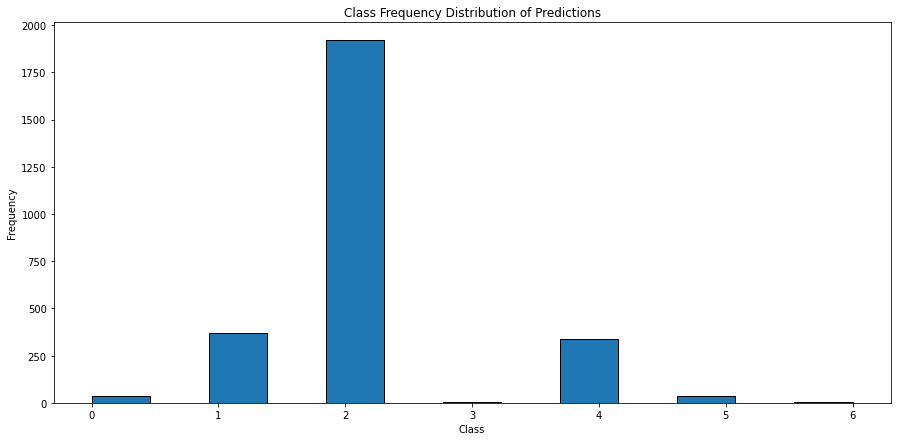

In [ ]:
fig = plt.figure(figsize = (15,7))
ax = fig.gca()
plt.hist(kmeans_result['Predictions'], edgecolor='black', bins='auto')
plt.title("Class Frequency Distribution of Predictions")
plt.xlabel("Class")
plt.ylabel("Frequency")

Mapping our label indexes from predictions with appropriate class in the ground truth.

In [ ]:
y, y_idx = pd.factorize(cora_content_str_subject["subject"])
y

array([0, 1, 2, ..., 5, 6, 0])

In [ ]:
y_mapping = {y_idx[k]: k for k in range(7) }
y_mapping

{'Neural_Networks': 0,
 'Rule_Learning': 1,
 'Reinforcement_Learning': 2,
 'Probabilistic_Methods': 3,
 'Theory': 4,
 'Genetic_Algorithms': 5,
 'Case_Based': 6}

Displaying an example of how the predicted cluster has nodes (ground truth) from different classes.

In [ ]:
kmeans_labels[y==0]

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2,
       2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2,
       2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 4,
       2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 4,
       2, 2, 2, 2, 2, 2, 2, 4, 4, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 4, 2, 2, 2, 2, 2, 5, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2,
       2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 4, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 5, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

np.bincount gives the number of occurences of different labels in a predicted cluster. We can see that, cluster 0 in predictions is dominated by label 2 (Reinforcement Learning).

In [ ]:
np.bincount(kmeans_labels[y==0])

array([  1,  15, 749,   0,  50,   3])

Here, using the first for loop, we are appending bincount of all the clusters to an array named 'hungarian'. 

In cases where there is absence of labels '6', '5', '4', the bincount generates an array with length < 7. This leads to an error saying `ValueError: expected a matrix (2-D array), got a (7,) array` because linear_sum_assignment is expecting a 2-D array. In order to overcome this error, we are using a for loop to append a zero whenever the length of array < 7, resulting in a 2-D array. 
It is clear that this will not alter the cluster results since the absence of value is direct result of 0 occurences.

Hungarian algorithm is used to find the minimum value and is most commonly used when you want to assign tasks to people based on minimum cost. But here, it works as a computational optimization technique by addressing the assignment problem. The assignment problem we are referring to here is, when two or more clusters are favoring same labels (classes). 

We use linear_sum_assignment from scipy.optimize module and set the parameter `maximize = True` in order to select clusters based on maximum occurrences of labels and effectively map them to the subject classes. 

In [ ]:
hungarian = []
for k in range(7):
    hungarian.append(np.bincount(kmeans_labels[y==k]))
for i in range(len(hungarian)):
  n = 7 - hungarian[i].size
  while(n!=0):
    hungarian[i] = np.append(hungarian[i], 0) 
    n-=1
# hungarian
_, hg_mapping = linear_sum_assignment(hungarian, maximize=True)

We are using inbuilt methods (accuracy_score, adjusted_rand_index, and normalized_mutual_info_score) from sklearn.metrics module to evaluate our model.

In [ ]:
acc = acc([hg_mapping[i] for i in y], kmeans_pca.labels_)

In [ ]:
print(f'ACC: {(acc):.3f}')
for m, m_name in [(nmi, 'NMI'), (ari, 'ARI')]:
    print(f'{m_name}: {m(y, kmeans_labels):.3f}')

ACC: 0.452
NMI: 0.202
ARI: 0.131


We can use t-SNE (t-distributed Stochastic Neighbor Embedding) from sklearn.manifold module or PCA (Principal Component Analysis) from sklearn.decomposition module for visualization of our Kmeans clustering. 

t-SNE is a tool for visualizing high-dimensional data using unsupervised learning techniques. t-SNE reduces the dimensionality of data by preserving the relationship between the samples.

In [ ]:
# transform = PCA
transform = TSNE
trans = transform(n_components = 2)
reduced_pca_scores = trans.fit_transform(scores_pca)
reduced_pca_scores

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


array([[ 20.156536 ,   7.076068 ],
       [-30.564713 ,  15.804856 ],
       [ 32.487915 ,   9.667063 ],
       ...,
       [ -0.8010216, -11.874269 ],
       [-17.305481 ,  19.556034 ],
       [-26.790018 ,   3.8482337]], dtype=float32)

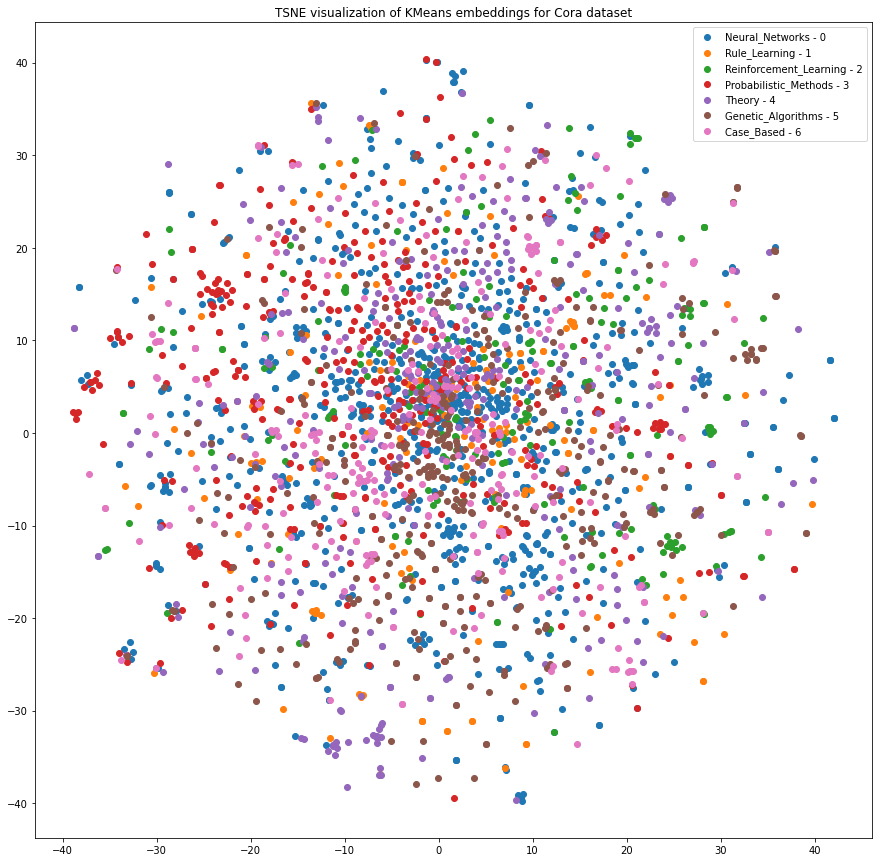

In [ ]:
keys = [k for k, v in y_mapping.items()]
unique_label = np.unique(kmeans_labels)
sc = plt.figure(figsize = (15,15))
for i in unique_label:
  plt.scatter(reduced_pca_scores[y==i, 0], reduced_pca_scores[y==i, 1], label = f"{keys[i]} - {i}")
plt.title(f"{transform.__name__} visualization of KMeans embeddings for Cora dataset")
plt.legend()
plt.show()